### Model and Predictions

In [1]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.compose import make_column_transformer, make_column_selector

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, Conv2D, MaxPool2D
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping
from keras.layers import SimpleRNN, LSTM, GRU, Dense
from keras import backend as K


In [5]:
df = pd.read_csv('data/clean_data_etsy.csv')

In [6]:
X = df.drop(columns = ['sales_count', 'creation_date', 'currency_code', 'shop_location'])
y = df['sales_count']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22) #train test split the variables

**Null Model** 

In [8]:
# baseline performance is ~30 sales
mean_y_array = np.full_like(y_test, y_test.mean())
np.round(mean_squared_error(y_test, mean_y_array, squared = False), 2)

29.92

In [9]:
r2_score(y_test, mean_y_array)

-0.00037338221029159513

**Linear Regression**

In [10]:
pipe_lr = make_pipeline(StandardScaler(), LinearRegression()) #instantiate a pipe with LR

In [11]:
# fit the data
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [12]:
pipe_lr.score(X_train, y_train)

0.5223974886420666

In [13]:
pipe_lr.score(X_test, y_test)

0.6763445661181624

In [14]:
# RMSE
np.round(mean_squared_error(y_test, pipe_lr.predict(X_test), squared = False), 2)

17.02

**RFE**

In [15]:
# instantiate RFE
rfe_lr = RFE(estimator = LinearRegression(), n_features_to_select = 10, step = 1)

In [16]:
# make pipeline
pipe_rfe_lr = make_pipeline(StandardScaler(), rfe_lr, LinearRegression())

In [17]:
# fit train data into the pipeline
pipe_rfe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=10)),
                ('linearregression', LinearRegression())])

In [18]:
# coefficient rankings 
rankings_lr = rfe_lr.ranking_

In [19]:
# construct a dataframe with coefficients
rfe_lr_df = pd.DataFrame({'rankings' : rankings_lr, 'names' : X.columns})

In [20]:
# display sorted values
rfe_lr_df.sort_values(by = 'rankings', inplace = True)
rfe_lr_df.head(10)

,rankings,names
0,1,listing_active_count
1,1,num_favorers
2,1,is_shop_us_based
3,1,sale_message
4,1,review_count


**Gradient Boosting Regressor**

In [21]:
pipe_boost = make_pipeline(StandardScaler(), GradientBoostingRegressor())

In [22]:
pipe_boost.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [23]:
pipe_boost.score(X_train, y_train)

0.9481353222284749

In [24]:
pipe_boost.score(X_test, y_test)

-0.24742971482794007

In [25]:
# RMSE
np.round(mean_squared_error(y_test, pipe_boost.predict(X_test), squared = False), 2)

33.41

**Random Forest Regressor**

In [26]:
pipe_forest = make_pipeline(StandardScaler(), RandomForestRegressor()) #instantiate a pipe with RF

In [27]:
# fit the data
pipe_forest.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [28]:
# score on the train data
pipe_forest.score(X_train, y_train)

0.919984714164558

In [29]:
# score on the train data
pipe_forest.score(X_test, y_test)

0.11934106624548868

In [30]:
# RMSE
np.round(mean_squared_error(y_test, pipe_forest.predict(X_test), squared = False), 4)

28.0708

**SVR**

In [31]:
# start a pipe
pipe_svr = make_pipeline(StandardScaler(), SVR())

In [32]:
pipe_svr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())])

In [33]:
pipe_svr.score(X_train, y_train)

0.44848588797428135

In [34]:
pipe_svr.score(X_test, y_test)

0.7642460870489037

In [35]:
# RMSE
np.round(mean_squared_error(y_test, pipe_svr.predict(X_test), squared = False), 2)

14.52

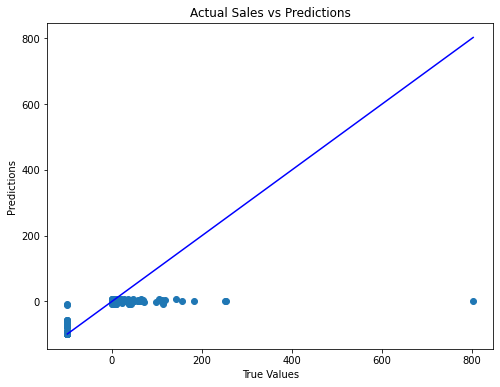

In [36]:
plt.figure(figsize = (8,6))
plt.scatter(y_test, pipe_svr.predict(X_test))
plt.xlabel('True Values', fontsize = 10)
plt.ylabel('Predictions', fontsize = 10) 
p1 = max(max(pipe_svr.predict(X_test)), max(y_test))
p2 = min(min(pipe_svr.predict(X_test)), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Actual Sales vs Predictions');

**GridSearch: SVR**

In [37]:
gs_svr = GridSearchCV(estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

In [38]:
gs_svr.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__cache_size', 'estimator__coef0', 'estimator__degree', 'estimator__epsilon', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [39]:
# grid_result_svr = gs_svr.fit(X_train, y_train)


**Neural Networks**

In [40]:
# instantiate StandardScaler
sscaler = StandardScaler() 

In [41]:
X_train_scaled = sscaler.fit_transform(X_train) #scale X_train

In [42]:
X_test_scaled = sscaler.transform(X_test) #scale X_test

In [43]:
# build a network 
model = Sequential()
model.add(Dense(200, kernel_initializer='normal',input_dim = X_train_scaled.shape[1], activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [44]:
# compile the model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

In [45]:
# fit the data
history = model.fit( 
    X_train_scaled,
    y_train,
    validation_data = (X_test_scaled, y_test),
    epochs = 35,
    verbose = 0
)

In [46]:
# evaluate the model
nn_model = model.evaluate(X_test_scaled, y_test)

157/157 [==============================] - 0s 1ms/step - loss: 288.7995 - mse: 288.7995


In [47]:
# rmse of the model with regularization
np.round(np.sqrt(nn_model), 2)

array([16.99, 16.99])

In [48]:
predictions = model.predict(X_test_scaled) # make predictions

In [49]:
# r-squared score
r2_score(y_test, predictions)

0.6772290860080457

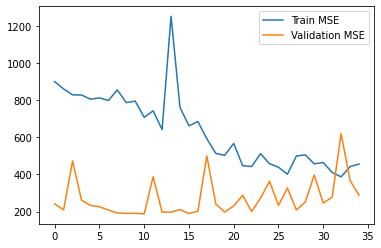

In [50]:
# plot Train and Validation MSE 
plt.plot(history.history['mse'], label = 'Train MSE')
plt.plot(history.history['val_mse'], label = 'Validation MSE')
plt.legend();

**Neural Network # 2**

In [51]:
# build a network 
model2 = Sequential()
model2.add(Dense(500, kernel_initializer='normal',input_dim = X_train_scaled.shape[1], activation='relu'))
model2.add(Dense(256, kernel_initializer='normal',activation='relu'))
model2.add(Dense(100, kernel_initializer='normal',activation='relu'))
model2.add(Dense(50, kernel_initializer='normal',activation='relu'))
model2.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [52]:
# compile the model
model2.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

In [53]:
# fit the data
history2 = model2.fit( 
    X_train_scaled,
    y_train,
    validation_data = (X_test_scaled, y_test),
    epochs = 50,
    verbose = 0
)

In [54]:
# evaluate the model
nn_model2 = model2.evaluate(X_test_scaled, y_test)

157/157 [==============================] - 0s 1ms/step - loss: 301.5663 - mse: 301.5663


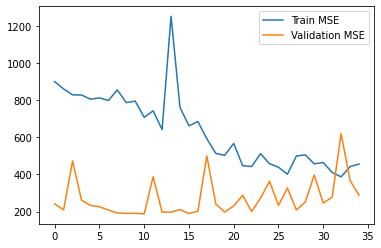

In [55]:
# plot Train and Validation MSE 
plt.plot(history.history['mse'], label = 'Train MSE')
plt.plot(history.history['val_mse'], label = 'Validation MSE')
plt.legend();